## Load libraries and Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json # import json for formatting data
import os # and os for saving
import boto3
import sagemaker
from sagemaker import get_execution_role

In [45]:
features_file = 'data/features.csv'
features_df = pd.read_csv(features_file)

stores_file = 'data/stores.csv'
stores_df = pd.read_csv(stores_file)

test_file = 'data/test.csv'
test_df = pd.read_csv(test_file)

train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)

train_df = train_df.merge(stores_df, how='left').merge(features_df, how='left')
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [46]:
# Save as Dataframe the train file and use Date as Index

train_df['Date'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in train_df['Date'].astype(str).values.tolist()]
train_df.index = train_df['Date']
train_df = train_df.drop(['Date'], axis=1)
train_df.sort_values(["Store","Dept"], ascending = (False,False))

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2010-02-12,1,1,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2010-02-19,1,1,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
2010-02-26,1,1,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
2010-03-05,1,1,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


## Convert features to use as dynamical features in DeepAR

In [47]:
def convert_features(train_df):
    # Convert IsHoliday as 1 or 0
    train_df['IsHoliday'] = train_df['IsHoliday'].astype(int)

    # replace store type by numbers 1,2,3
    train_df.Type.replace(['A','B','C'], [1, 2, 3], inplace = True)

    # MarkDown Nan = O, Others = 1
    train_df.fillna(0, inplace=True)
    list=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
    for i in list:
        train_df.loc[train_df[i] != 0, i] = 1
        
    train_df.replace('NaN', 0, inplace = True)

In [48]:
convert_features(train_df)
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2010-02-12,1,1,46039.49,1,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2010-02-19,1,1,41595.55,0,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
2010-02-26,1,1,19403.54,0,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
2010-03-05,1,1,21827.90,0,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


In [49]:
# Look at the Store list to see if there are missing numbers
print(train_df.Store.unique())
print(train_df.Store.nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
45


In [50]:
# Look at the Dept list to see if there are missing numbers
print(train_df.Dept.unique())
print(train_df.Dept.nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39 50 43 65]
81


In DeepAR, Categorical features must be encoded as a 0-based sequence of positive integers.  
https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html  
We want a list of 45 Stores and another of 81 Departments, each starting by 0

In [51]:
# Add Cat_Store columns to convert Store to a "Category" field appropriate for DeepAR
train_df['Cat_Store'] = train_df['Store'] - 1

# Add Cat_Dept columns to convert Dept to a "Category" field appropriate for DeepAR
liste = range(81)
for i in liste:
    department = train_df.Dept.unique()[i]
    train_df.loc[train_df['Dept'] == department, 'Cat_Dept'] = int(i)  

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Cat_Store,Cat_Dept
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,0.0
2010-02-12,1,1,46039.49,1,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,0.0
2010-02-19,1,1,41595.55,0,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,0.0
2010-02-26,1,1,19403.54,0,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,0.0
2010-03-05,1,1,21827.90,0,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,0.0


In [52]:
# Verify Cat_Store
print(train_df.Cat_Store.unique())
print(train_df.Cat_Store.nunique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
45


In [53]:
# Verify Cat_Dept
print(train_df.Cat_Dept.unique())
print(train_df.Cat_Dept.nunique())

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80.]
81


In [54]:
# take only 2 stores to stay within AWS Sagemaker size limit when using the deployed model to predict
train_df = train_df[train_df.Store < 3]
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Cat_Store,Cat_Dept
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,0.0
2010-02-12,1,1,46039.49,1,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,0.0
2010-02-19,1,1,41595.55,0,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,0.0
2010-02-26,1,1,19403.54,0,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,0.0
2010-03-05,1,1,21827.90,0,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,0.0


## Plot Sales Evolution

In [55]:
# Define a function to plot sales evolution depending of the store and department number
def sales_evolution(store_number, dept_number):
    example_store_dept_sales = train_df[(train_df.Store == store_number) & (train_df.Dept == dept_number)]['Weekly_Sales']
    plt.figure(figsize=(8,3))
    example_store_dept_sales.plot(title='Store {} Dpt {} Sales evolution'.format(store_number, dept_number), color='blue') 
    return plt.show()

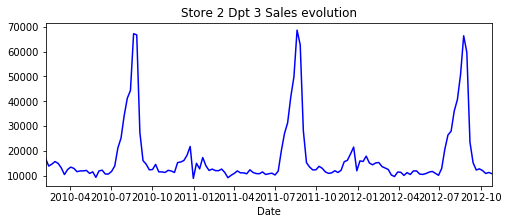

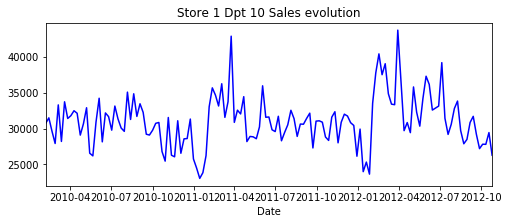

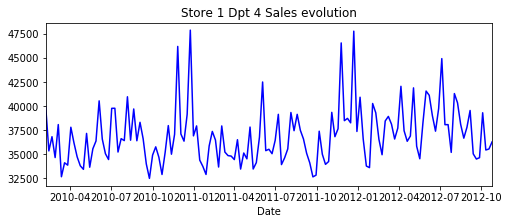

In [56]:
# Plot some examples
sales_evolution(2,3)
sales_evolution(1,10)
sales_evolution(1,4)

## Create and display complete time series

In [57]:
def make_dyn_feat(df, features, prediction_length, freq='W-FRI'):
    '''Create dynamic_features for each stores, each years and each selected features
      :param df: dataframe with train data. Contain at least the selected features in columns and Store number
          This dataframe should also be indexed by a datetime.
      :param features : list of choosen dynamical features, evolving over time
      :param years: A list of years to make time series out of, ex. ['2010', '2011'].
      :param prediction_length : length of dyn_features = 52 - prediction_length (usefull for training series)
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A 3 dimensional list : Store / year / features
      '''

    # instantiate dynamic features list
    dynamic_feat = []
    
    # create dynamic feature for each store 
    for store in df.Cat_Store.unique().tolist():
        
        # instantite store list
        store_feat=[]
        
        # select features columns and filter on store number.
        # choose one Dept to have only one line for each date
        # Dynamic features are linked to the store, not the departments
        dyn_df = df.loc[(df.Cat_Store == store) & (df.Cat_Dept == 1), features]
        
        # initialise start_idx
        start_idx = 0
        # we get 144 weeks in our dataset, starting at index 0
        end_idx = start_idx + 143 - prediction_length

        # get wanted sample_df data
        dyn_temp_df = dyn_df[start_idx:end_idx]

        for j in features:
            store_feat.append(dyn_temp_df[j].tolist())
            
        if df['Cat_Store'].nunique() > 1:
            dynamic_feat.append(store_feat)
        else:
            dynamic_feat = store_feat
    return dynamic_feat

In [58]:
# Create dynamic features for all data
freq='W-FRI' # weekly recordings
features = ['IsHoliday','MarkDown1','Temperature']
# prediction length for test set
prediction_test = 0

# make dynamic features test series
test_dynamic_features = make_dyn_feat(train_df, features,prediction_test, freq=freq)

# print(test_dynamic_features)

In [59]:
def make_time_series(df, freq='W-FRI'):
    '''Creates as many time series as they are stores x departments
      :param df: dataframe with train data. One 3 columns : Store, Dept, Weekly_Sales.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2010', '2011'].
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # create time series for each store and each department
    for store in df.Cat_Store.unique().tolist():
        for dept in df.Cat_Dept.unique().tolist():
            
            # create DataFrame with weekly_sales for the store and department studied
            sample_df = df[(df.Cat_Store == store) & (df.Cat_Dept == dept)]['Weekly_Sales']   
            
            # initialise start_idx
            start_idx = 0
            end_idx = start_idx+143

            # create start and datetime
            t_start = '2010-02-05' # start with first date 

            # get wanted sample_df data
            data = sample_df[start_idx:end_idx]

            # create time series for the year
            index = pd.date_range(start=t_start, periods=143, freq=freq)
            Serie_df = pd.Series(data=data, index=index)

            # include info of the store and dept as last values to use as category in DeepAR
            Info_df = pd.Series(data=[int(store), int(dept)], index=['store','dept'])
            time_series.append(pd.concat([Serie_df, Info_df]))               
    
    # return list of time series
    return time_series

In [60]:
# Create time series for all store and departments
freq='W-FRI' # weekly recordings

# make time series
time_series = make_time_series(train_df, freq=freq)

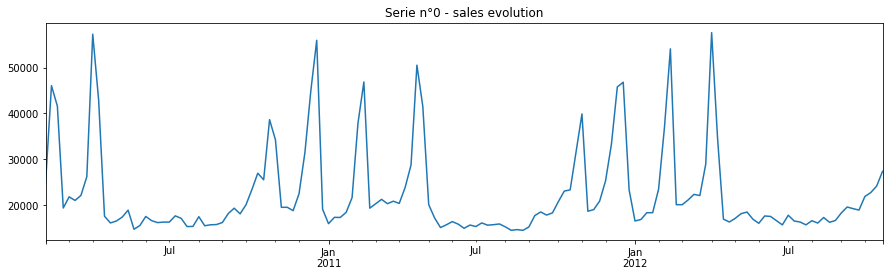

In [61]:
# display first time series
time_series_idx = 0

# plot time series except the last two values corresponding to store and department
plt.figure(figsize=(15,4))
time_series[time_series_idx][:-2].plot(title='Serie n°{} - sales evolution'.format(time_series_idx))
plt.show()

## Splitting in Time

In [62]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        
        # save store and departement number for the serie as Info
        Info_df = ts[-2:]
        
        # truncate "prediction_length" weeks + 2 corresponding to the store and departement number
        truncate = prediction_length + 2
        Train_Serie_df = ts[:-truncate]
        
        # save Train_Serie with its Info
        time_series_training.append(pd.concat([Train_Serie_df, Info_df]))
        
    return time_series_training

In [63]:
# set prediction length to 36 weeks ~ 9 months that we will have to forecast with the trained model
prediction_length = 36 

time_series_training = create_training_series(time_series, prediction_length)

In [64]:
# make dynamic features for train series
train_dynamic_features = make_dyn_feat(train_df, features, prediction_length, freq=freq)

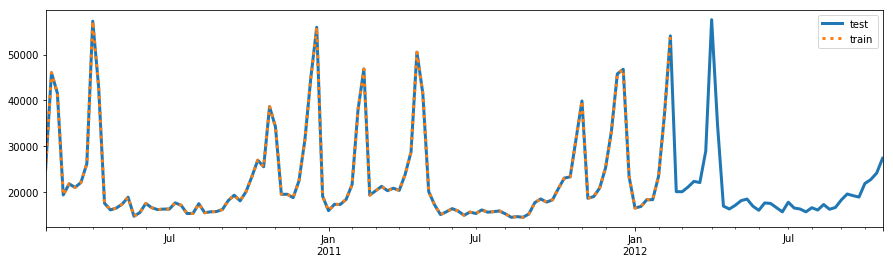

In [65]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,4))
# test data is the whole time series
time_series[time_series_idx][:-2].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx][:-2].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON

In [66]:
def series_to_json_obj(ts, dynamic_features):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target and cat from the time series, ts
    if len(ts)< 3:
        target = []
    else:
        target = list(ts[:-2])
    no_nan_target = pd.Series(target).fillna(0).tolist()
    
    # get dynamic_feat related to the store and the year (same dynamic_feat for all department of one store)
    store = int(ts[-2])
    
    json_obj = {"start": str(ts.index[0]),
                "target": no_nan_target,
                "cat": list(map(int, ts[-2:])),
                "dynamic_feat": dynamic_features[store]
               }
    return json_obj

In [67]:
# test out the code
ts = time_series_training[0]

json_obj = series_to_json_obj(ts,train_dynamic_features)

print(json_obj)

{'start': '2010-02-05 00:00:00', 'target': [24924.5, 46039.49, 41595.55, 19403.54, 21827.9, 21043.39, 22136.64, 26229.21, 57258.43, 42960.91, 17596.96, 16145.35, 16555.11, 17413.94, 18926.74, 14773.04, 15580.43, 17558.09, 16637.62, 16216.27, 16328.72, 16333.14, 17688.76, 17150.84, 15360.45, 15381.82, 17508.41, 15536.4, 15740.13, 15793.87, 16241.78, 18194.74, 19354.23, 18122.52, 20094.19, 23388.03, 26978.34, 25543.04, 38640.93, 34238.88, 19549.39, 19552.84, 18820.29, 22517.56, 31497.65, 44912.86, 55931.23, 19124.58, 15984.24, 17359.7, 17341.47, 18461.18, 21665.76, 37887.17, 46845.87, 19363.83, 20327.61, 21280.4, 20334.23, 20881.1, 20398.09, 23873.79, 28762.37, 50510.31, 41512.39, 20138.19, 17235.15, 15136.78, 15741.6, 16434.15, 15883.52, 14978.09, 15682.81, 15363.5, 16148.87, 15654.85, 15766.6, 15922.41, 15295.55, 14539.79, 14689.24, 14537.37, 15277.27, 17746.68, 18535.48, 17859.3, 18337.68, 20797.58, 23077.55, 23351.8, 31579.9, 39886.06, 18689.54, 19050.66, 20911.25, 25293.49, 33305.92

## Saving Data, Locally

In [68]:
def write_json_dataset(time_series, dynamic_features, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts,dynamic_features)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [69]:
# save this data to a local directory
data_dir = 'json_sales_data_dyn'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [70]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_dynamic_features, train_key)        
write_json_dataset(time_series, test_dynamic_features, test_key)

json_sales_data_dyn/train.json saved.
json_sales_data_dyn/test.json saved.


## Uploading data to S3

In [71]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

In [72]:
# general prefix
prefix='deepar-weekly-sales'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [73]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-eu-central-1-293973958717/deepar-weekly-sales/train/train.json
Test data is stored in: s3://sagemaker-eu-central-1-293973958717/deepar-weekly-sales/test/test.json


# Training a DeepAR Estimator

## Instantiate an Estimator

In [74]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

In [75]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

## Setting Hyperparameters

In [76]:
freq='W'
context_length=36 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [77]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## Training job

In [78]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-06-24 18:11:45 Starting - Starting the training job...
2020-06-24 18:11:46 Starting - Launching requested ML instances......
2020-06-24 18:12:53 Starting - Preparing the instances for training...
2020-06-24 18:13:31 Downloading - Downloading input data
2020-06-24 18:13:31 Training - Downloading the training image......
2020-06-24 18:14:33 Training - Training image download completed. Training in progress.Arguments: train
[06/24/2020 18:14:35 INFO 140622519084864] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'au

## Deploy and Create a Predictor¶

In [82]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

Using already existing model: forecasting-deepar-2020-06-24-18-11-44-925


------------------!CPU times: user 322 ms, sys: 46.5 ms, total: 369 ms
Wall time: 9min 3s


## JSON Prediction Request
The code below accepts a list of time series as input and some configuration parameters. It then formats that series into a JSON instance and converts the input into an appropriately formatted JSON_input.

In [83]:
def json_predictor_input(input_ts, dynamic_feat, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series providing all dynamic features
        instances.append(series_to_json_obj(input_ts[k],dynamic_feat))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

## Get a Prediction
We can then use this function to get a prediction for a formatted time series  
In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [84]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

# get formatted input time series
json_input_ts = json_predictor_input(input_ts, test_dynamic_features)



In [85]:
# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

# print(json_prediction)




In [86]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [87]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 4 predictions 
# with corresponding quantile values
print(prediction_list[0])

             0.1           0.9           0.5
0   25110.351562  36896.007812  29689.976562
1   22946.439453  31185.404297  27529.066406
2   22206.675781  30084.525391  26518.082031
3   22043.296875  30195.558594  25991.009766
4   20740.845703  31111.451172  25413.365234
5   21709.957031  32991.171875  27109.632812
6   22451.779297  31515.871094  27227.058594
7   25992.990234  32247.472656  28453.371094
8   23212.281250  32556.726562  27952.632812
9   24264.468750  32757.519531  27715.779297
10  22058.410156  29611.257812  25554.177734
11  21766.507812  28245.324219  24886.187500
12  21523.468750  28563.611328  24553.927734
13  18575.101562  27008.474609  24019.093750
14  20091.632812  28128.294922  23855.341797
15  19813.361328  28490.771484  24094.562500
16  20062.193359  27220.777344  23756.560547
17  20954.423828  26742.277344  23237.363281
18  18841.312500  26495.833984  23406.093750
19  20835.199219  27507.535156  23406.480469
20  20429.628906  27413.482422  23972.343750
21  20569.

## Display the Results
The quantile data will give us all we need to see the results of our prediction.  
Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.  
Quantile 0.5 represents the median of all sample predictions.

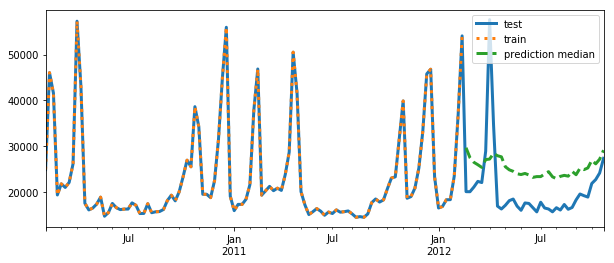

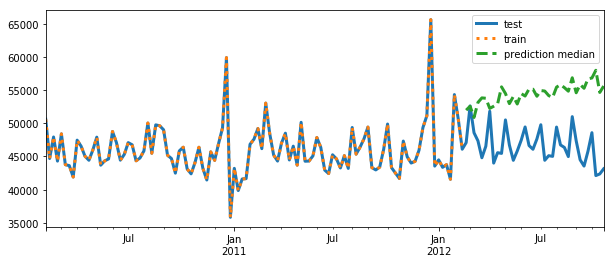

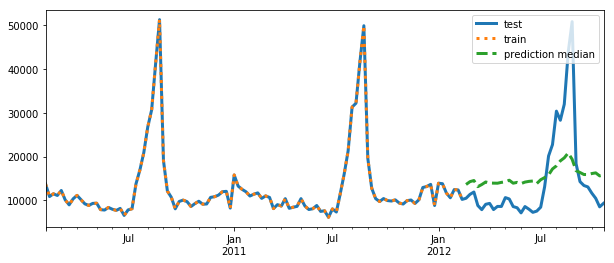

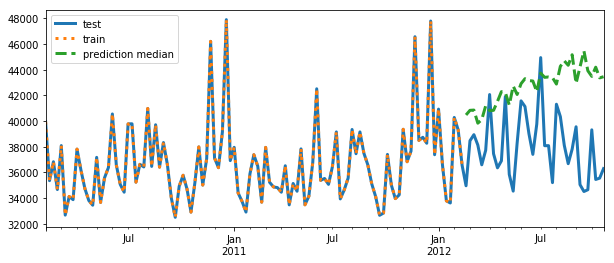

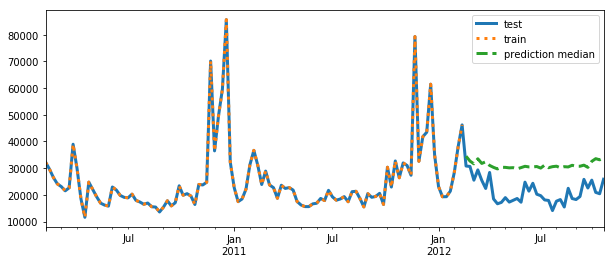

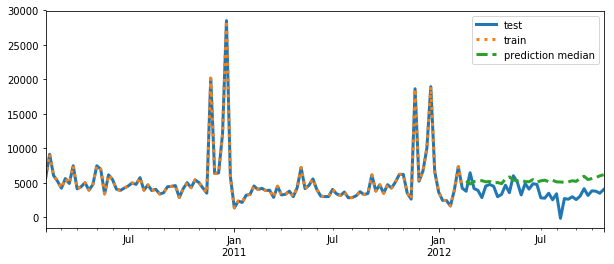

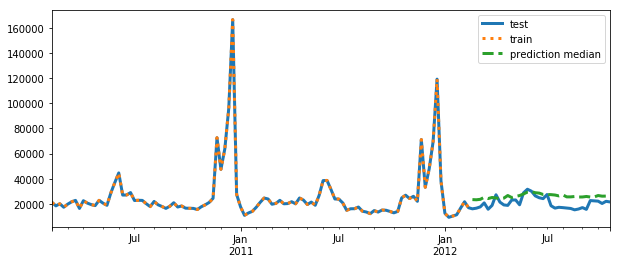

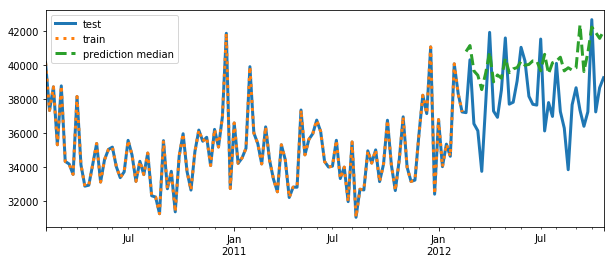

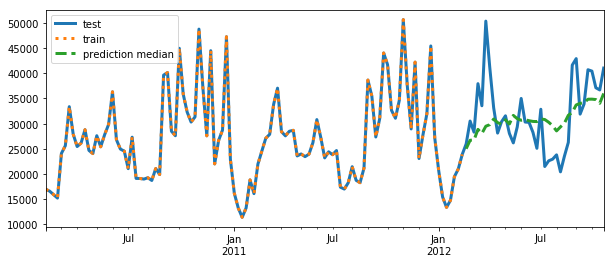

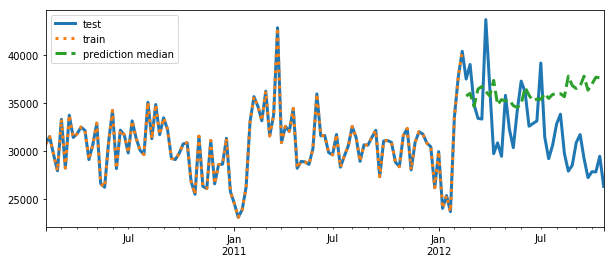

In [107]:
# display train/test time series and prediction median

for time_series_idx in range(10):

    pred_df = prediction_list[time_series_idx]['0.5']
    pred_df.index = time_series[time_series_idx][-38:-2].index
    pred_df

    plt.figure(figsize=(10,4))
    # test data is the whole time series
    time_series[time_series_idx][:-2].plot(label='test', lw=3)
    # train data is all but the last prediction pts
    time_series_training[time_series_idx][:-2].plot(label='train', ls=':', lw=3)

    pred_df.plot(label='prediction median', ls="--", lw=3)

    plt.legend()
    plt.show()

In [108]:
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    
    # for k in range(len(prediction_list)):
    # len(prediction_list = 1580 for 10 stores so plot only some examples)
    
    for k in range(10):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        
        # plot the median prediction line
        p50 = prediction_list[k]['0.5']
        plt.plot(p10.index, p50 , label='prediction median')
        
        plt.legend()
        plt.show()

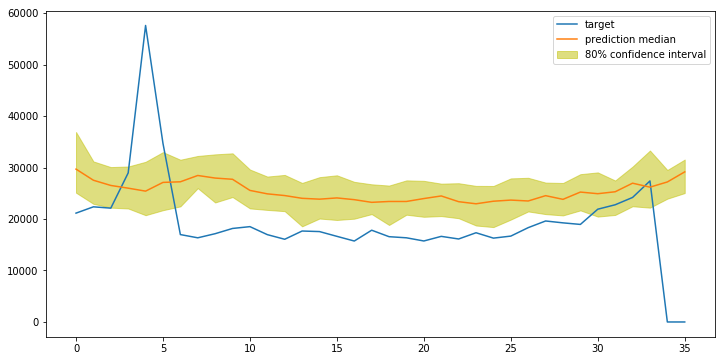

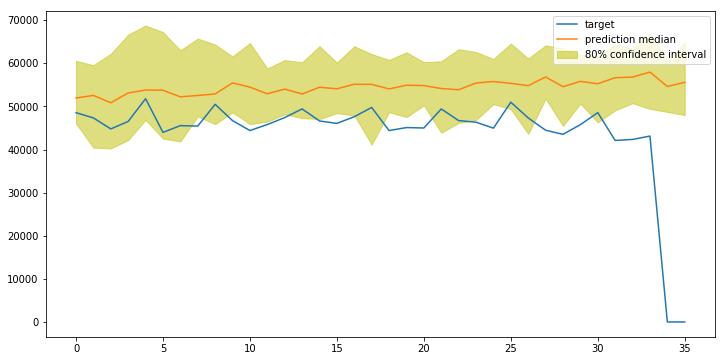

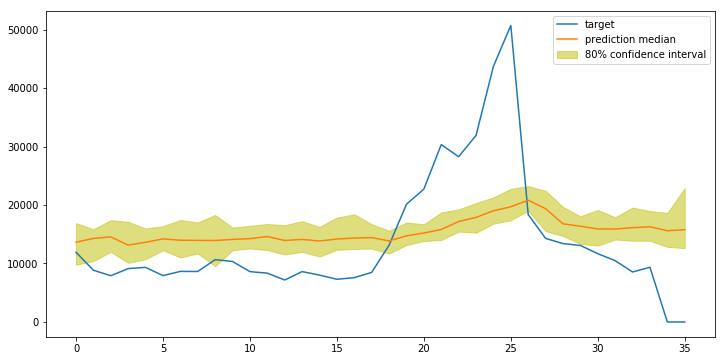

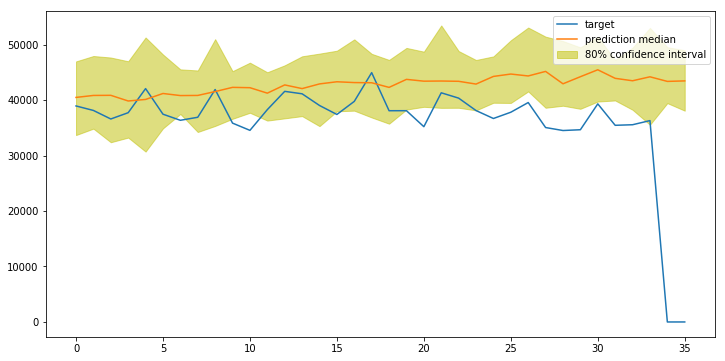

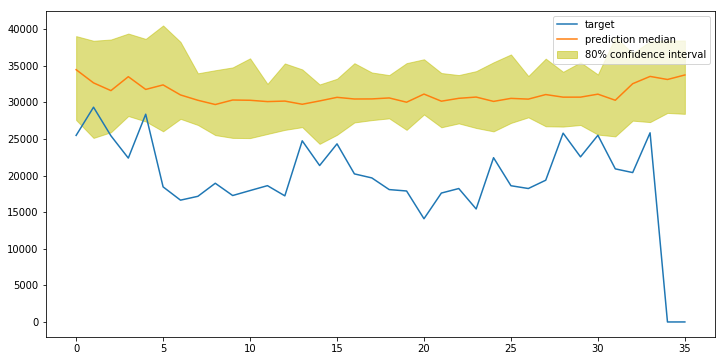

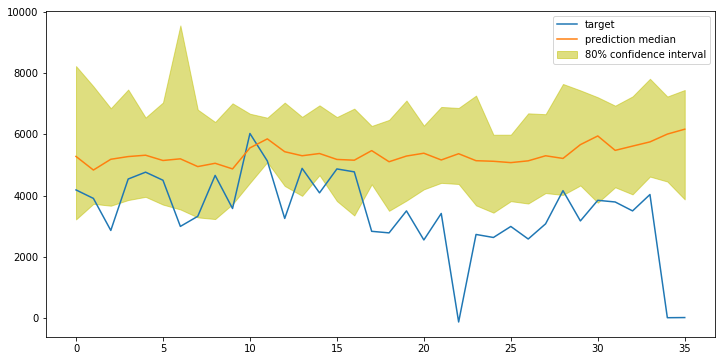

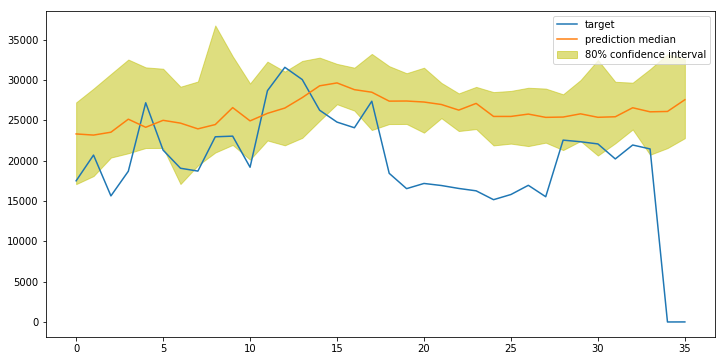

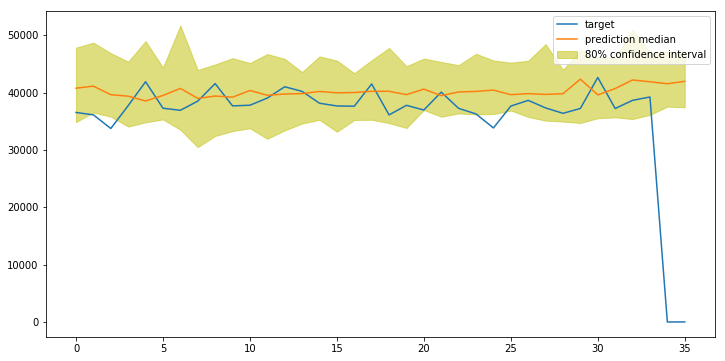

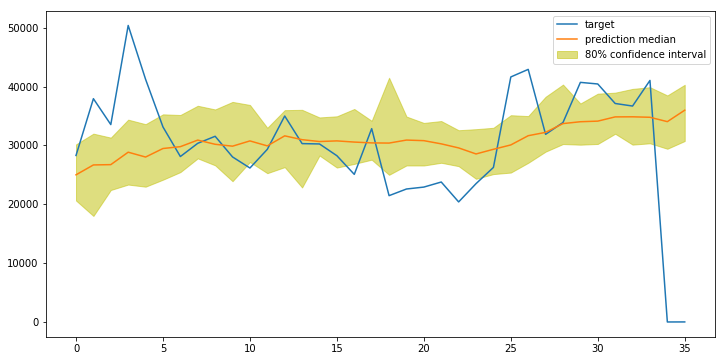

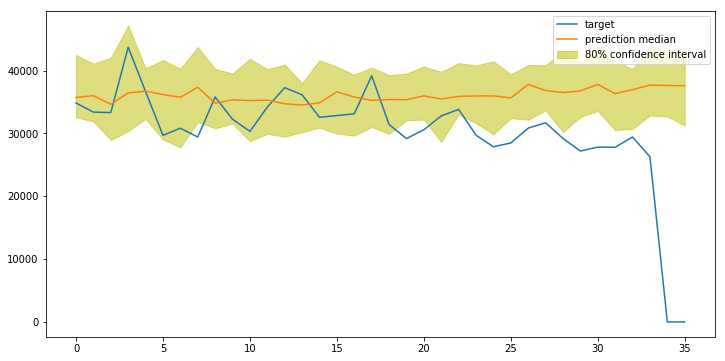

In [109]:
# display predictions
display_quantiles(prediction_list, target_ts)

## Future prediction

Work in progress from this point

In [182]:
def make_dyn_feat_future(df, features, years, prediction_length, period, freq='W-FRI'):
    '''Create dynamic_features for each stores, each years and each selected features
      :param df: dataframe with train data. Contain at least the selected features in columns and Store number
          This dataframe should also be indexed by a datetime.
      :param features : list of choosen dynamical features, evolving over time
      :param years: A list of years to make time series out of, ex. ['2010', '2011'].
      :param prediction_length : length of dyn_features = 52 - prediction_length (usefull for training series)
      :param period : number of week to create (52 for one complete year)
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A 3 dimensional list : Store / year / features
      '''

    # instantiate dynamic features list
    dynamic_feat = []
    
    # create dynamic features for each store 
    for store in df.Cat_Store.unique().tolist():
        
        # instantite store list
        store_feat=[]
        
        # select features columns and filter on store number.
        # choose one Dept to have only one line for each date
        # Dynamic features are linked to the store, not the departments
        dyn_df = df.loc[(df.Cat_Store == store) & (df.Cat_Dept == 1), features]
        
        # initialise start_idx
        start_idx = 0
        
        # create dynamic feature for each year in years
        for i in range(len(years)):
            years_feat=[]
            year = years[i]
            end_idx = start_idx + period - prediction_length

            # get wanted sample_df data
            dyn_temp_df = dyn_df[start_idx:end_idx]
            
            for j in features:
                years_feat.append(dyn_temp_df[j].tolist())
            
            if len(years) > 1:
                store_feat.append(years_feat)
                # start next year in loop
                start_idx = end_idx + prediction_length + 1
            else:
                store_feat = years_feat
            
        if df['Cat_Store'].nunique() > 1:
            dynamic_feat.append(store_feat)
        else:
            dynamic_feat = store_feat
    return dynamic_feat

In [183]:
# Create dynamic features for our 38 weeks to forecast

full_years = ['2012']
freq='W-FRI' # weekly recordings
features = ['IsHoliday','MarkDown1','Temperature']
# prediction length for test set
prediction_test = 0
# from 2012-02-10 to 2012-10-26, 38 weeks to forecast
period = 38

# make dynamic features test series
forecast_dynamic_features = make_dyn_feat_future(train_df, features, full_years,prediction_test, period, freq=freq)

# print(forecast_dynamic_features)

In [185]:
def make_time_series_future(df, years, period, freq='W-FRI'):
    '''Creates as many time series as they are stores x departments x complete years. 
      :param df: dataframe with train data. One 3 columns : Store, Dept, Weekly_Sales.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2010', '2011'].
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # create time series for each store and each department
    for store in df.Cat_Store.unique().tolist():
        for dept in df.Cat_Dept.unique().tolist():
            
            # create DataFrame with weekly_sales for the store and department studied
            sample_df = df[(df.Cat_Store == store) & (df.Cat_Dept == dept)]['Weekly_Sales']   
            
            # initialise start_idx
            start_idx = 104
            
            # create time series for each year in years
            for i in range(len(years)):

                # for each time series, length = period number of weeks
                year = years[i]
                end_idx = start_idx + period + 1

                # create start and end datetimes
                t_start = year + '-02-05' # start with first date 
                # t_end = str(int(year)+1) + '-01-31' # end friday one year later 28

                # get wanted sample_df data
                data = sample_df[start_idx:end_idx]
                
                # create time series given the period number of weeks
                index = pd.date_range(start=t_start, periods=period, freq=freq)
                Serie_df = pd.Series(data=data, index=index)
                
                # include info of the store and dept as last values to use as category in DeepAR
                Info_df = pd.Series(data=[int(store), int(dept)], index=['store','dept'])
                time_series.append(pd.concat([Serie_df, Info_df]))
                
                # start next year in loop
                start_idx = end_idx+1                
    
    # return list of time series
    return time_series

In [186]:
# Create yearly time series 
full_years = ['2012']
freq='W-FRI' # weekly recordings

# from 2012-02-10 to 2012-10-26, 38 weeks to forecast
period = 38

# make time series
target_time_series = make_time_series_future(train_df, full_years, period, freq=freq)

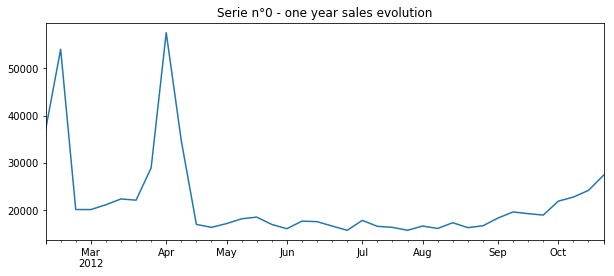

In [187]:
# display first time series
time_series_idx = 0

# plot time series except the last two values corresponding to store and department
plt.figure(figsize=(10,4))
target_time_series[time_series_idx][:-2].plot(title='Serie n°{} - one year sales evolution'.format(time_series_idx))
plt.show()

In [188]:
# set prediction length
prediction_length = 38 

empty_time_series = create_training_series(target_time_series, prediction_length)

In [189]:
def series_to_forecast_json_obj(complete_ts, dynamic_features):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param complete_ts: A single time series. we will only use the index to get the start date
       :return: A dictionary of values with "start" and "target" keys.
       '''

    # We set an empty list as target
    target = []
    
    # get dynamic_feat related to the store and the year (same dynamic_feat for all department of one store)
    store = int(complete_ts[-2])
    
    #select year from index
    #year = str(complete_ts.index[0])[0:4]
    #if year == '2012':
    #    serie = 0
    #else:
    #    serie = 1
    
    json_obj = {"start": str(complete_ts.index[0]),
                "target": target,
                "cat": list(map(int, complete_ts[-2:])),
                "dynamic_feat": dynamic_features[store]
               }
    return json_obj

In [190]:
def json_predictor_input_forecast(input_ts, dynamic_feat, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series providing all dynamic features
        instances.append(series_to_forecast_json_obj(input_ts[k],dynamic_feat))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

In [ ]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

In [191]:
# get all input and target (test) time series
input_ts = empty_time_series
target_ts = target_time_series

# get formatted input time series
json_input_ts = json_predictor_input_forecast(target_ts, forecast_dynamic_features)

In [192]:
# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

# print(json_prediction)

In [195]:
# get quantiles/predictions
prediction_2012 = decode_prediction(json_prediction)

# should get a list of 38 predictions 
# with corresponding quantile values
print(prediction_2012[0])

           0.1           0.9           0.5
0   272.151367  31947.871094  12883.132812
1  4261.965820  19822.021484  10973.197266
2  4239.345215  17781.636719  11665.267578
3  2981.695312  19341.269531  10777.799805


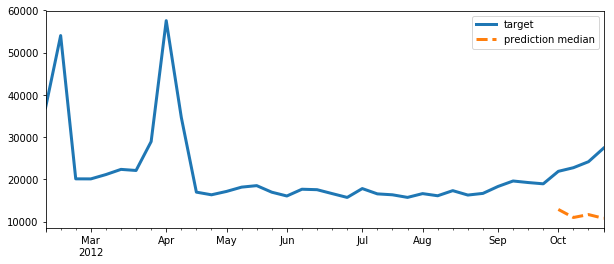

In [198]:
# display train/test time series and prediction median
time_series_idx = 0

pred_df = prediction_list[time_series_idx]['0.5']
pred_df.index = target_time_series[time_series_idx][-6:-2].index

plt.figure(figsize=(10,4))
# test data is the whole time series
target_time_series[time_series_idx][:-2].plot(label='target', lw=3)

# no train data in this case
# train data is all but the last prediction pts
#time_series_training[time_series_idx][:-2].plot(label='train', ls=':', lw=3)

# plot the prediction median
pred_df.plot(label='prediction median', ls="--", lw=3)

plt.legend()
plt.show()

In [110]:
# delete the endpoint
predictor.delete_endpoint()